Part Three
===
Learning Arch/Garch Models by arch mudule
---

<img src="imgs/ARIMA1.png" width="600" height="300" usemap="#ARIMAMap" />
<map name="ARIMAMap">
  <area shape="rect" coords="10,10,300,60" href="#1.-Load-Data" />
  <area shape="rect" coords="50,80,330,130" href="#2.-Non-Stationary-and-Stationary-Time-Series" />
  <area shape="rect" coords="90,150,380,200" href="#3.-Plot-the-ACF/PACF-charts-and-find-the-optimal-parameters" />
  <area shape="rect" coords="130,230,420,280" href="#4.-ARMA-Model-Introduce" />
  <area shape="rect" coords="400,120,590,180" href="#5.-Forecast-System" />
  
</map>

In [14]:
from IPython.core.display import HTML
css_file = 'css/ngcmstyle.css'
HTML(open(css_file, "r").read())

In [5]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw Python code, click <a href="javascript:code_toggle()">
[<code style="background-color:brown;color:yellow;"> here </code>]</a>.''')


## Approximation by 
1. Deterministic Method or 
- by Probabilistic Method?


In [6]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from xlsxwriter.utility import xl_rowcol_to_cell
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage.interpolation import shift
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import ADF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

try:
   import seaborn
except ImportError:
    pass
%matplotlib inline

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


1. Load Data
---
At first, We want to visualize the data, yearly Taiwan CPI index from 1973 to 2011, to understand what type of model we should use.
  - Is there an overall trend in your data that you should be aware of? 
  - Does the data show any seasonal trends?

This is important when deciding which type of model to use. If there isn’t a seasonal trend in your data, then you can just use a regular ARIMA model instead. If you are using daily data for your time series and there is too much variation in the data to determine the trends, you might want to look at resampling your data by month, or looking at the rolling mean.  

**Subjects**<br>
1. data: change date-index into Pandas-compliant "datetime" format, ```pandas.to_datetime```;
- observe data by ```qgrid.show_grid```,
- data visualisation, any seasonality check, ```statsmodels.tsa.seasonal.seasonal_decompose```.

In [7]:
df=pd.read_csv('data/taiwan-2016-by-date.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 2015-01-06 to 2016-01-20
Data columns (total 1 columns):
num    198 non-null int64
dtypes: int64(1)
memory usage: 3.1+ KB


Convert Index into legal DatetimeIndex for use lately.

In [8]:
# if necessary, convert the index to datetime format
df.index=pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 2015-01-06 to 2016-01-20
Data columns (total 1 columns):
num    198 non-null int64
dtypes: int64(1)
memory usage: 3.1 KB


In [9]:
import qgrid

In [10]:
qgrid.nbinstall(overwrite=True) 

In [11]:
qgrid.show_grid(df, show_toolbar=True, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})

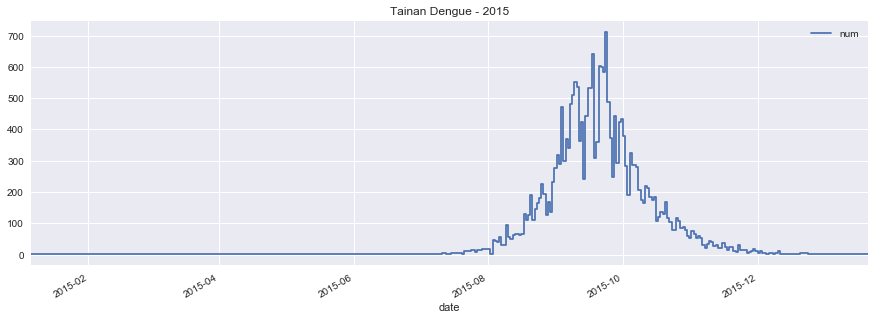

In [12]:
df.plot(title='Tainan Dengue - 2015',figsize=(15,5),drawstyle='steps');

As above visualisation, there is no seasonality there maybe caused of short of data collection.

2. Non-Stationary and Stationary Time Series
---
**Subjects**<br>
1. What stationary means: For time series, $\{X_t\}_{t=1,2,\cdots}$
   - Strong Stationary, (only for math study, but useless in applications): for any $\tau$
     $$ F_X(x_{t_1},x_{t_2},\cdots,x_{t_n})=F_X(x_{t_1+\tau},x_{t_2+\tau},\cdots,x_{t_n+\tau})$$
     where $F_X$ is jointly distribution for any $(t_1,t_2,\cdots,t_n)$ in $T$; 
     ```
     History always repeates itself!
     ```
   - Weakly Stationary: 
     - **a)** Finite expectation, $\mathbb{E} X_t=\mu$ and second order of moment of $\{X_t\}$, 
     - **b)** time independent of 
     any **$l$**-order autocovariance:
     $$\gamma_{t_k}=\mathbb{E}(X_{t_k}-\mu)(X_{t_k-l}-\mu)=\gamma_{t_k+h}$$
     
- <a href="#Kinds-of-Time-Series-Data">Kinds of Times Series</a>
- <a href="#Stationarity-Test">test whether stationary time series data is</a>,
- <a href="#Stationary-Transform">transform un-stationary one into stationary one if necessary</a>.



Formally, types of popular non-stationary times series include:

|Type|Math Formulation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|Process to Stationalized;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:------:|:-------------------------|:---|
|Pure Random Walk|$X_t=X_{t-1}+\varepsilon_t$|$Y_t=X_t-X_{t-1}=\varepsilon_t$ (<font color="brown">by difference</font>)|
|Pure Random Walk<br>with drift|$X_t=\alpha+X_{t-1}+\varepsilon_t$|$Y_t=X_t-X_{t-1}=\alpha+\varepsilon_t$ (<font color="brown">by difference</font>)|
|Deterministic Trend|$X_t = \alpha + \beta t + \varepsilon_t $|$Y_t=X_t-\alpha-\beta t=\varepsilon_t$ (<font color="brown">by detrend</font>)|
|Random Walk with Drift,<br> Deterministic Trend |$X_t = \alpha + X_{t-1} + \beta t + \varepsilon_t $|$Y_t=X_t-\alpha-\beta t=X_{t-1}+\varepsilon_t$ (<font color="brown">by detrend</font>)<br> $Z_t=Y_t-Y_{t-1}$ (<font color="brown"> and by difference</font>))
where $\varepsilon_t\sim N(0,\sigma^2)$. The disadvantage of difference method is loss one of observation.



Kinds of Time Series Data
---

In [8]:
epsilon=np.random.randn(100)/10
x0=np.random.randn(100)

alpha=0.5
betat=0.1*np.linspace(0,len(x0)-1,100)
Xt=epsilon+x0
f1=Xt+shift(Xt, 1, cval=0)

Xt=alpha+epsilon+x0
f2=Xt+shift(Xt, 1, cval=0)

f3=alpha+betat+epsilon

Xt=alpha+epsilon+x0++betat
f4=Xt+shift(Xt, 1, cval=0)

In [14]:
epsilon=np.random.randn(100)

alpha=0.06
beta=0.005

f1= np.zeros(100)
f2= np.zeros(100)
f3= np.zeros(100)
f4= np.zeros(100)
f1[0]=f2[0]=f3[0]=f4[0]=np.random.randn()
for i in range(1,100):
    f1[i]=f1[i-1]+epsilon[i]
    f2[i]=alpha+f2[i-1]+epsilon[i]
    f3[i]=alpha+beta*i+epsilon[i]
    f4[i]=alpha+beta*i+f4[i-1]+epsilon[i]

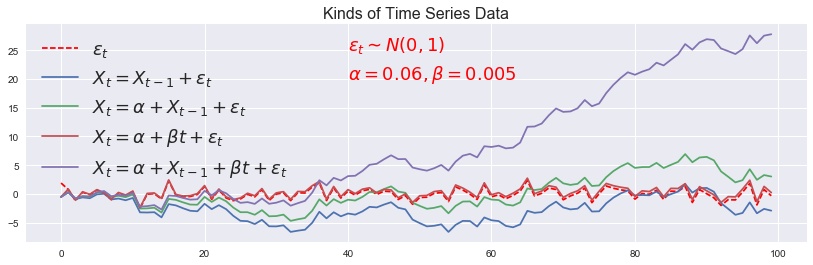

In [18]:
plt.figure(figsize=(14,4))
plt.plot(epsilon,'r--',label="$\\varepsilon_t$")
plt.plot(f1,label="$X_t=X_{t-1}+\\varepsilon_t$")

plt.plot(f2,label="$X_t=\\alpha+X_{t-1}+\\varepsilon_t$")
plt.plot(f3,label="$X_t=\\alpha+\\beta t+\\varepsilon_t$")
plt.plot(f4,label="$X_t=\\alpha+X_{t-1}+\\beta t+\\varepsilon_t$")

plt.text(40,25,'$\\varepsilon_t\\sim N(0,1)$',size=18,color='red')
plt.text(40,20,'$\\alpha=0.06,\\beta=0.005$',size=18,color='red')
plt.title("Kinds of Time Series Data",size=16)
plt.legend(fontsize=18)

Stationarity Test
---

In statistics and econometrics, an **augmented Dickey–Fuller test (ADF)** tests the null hypothesis, $H_0$, of a unit root is present in a time series sample. The alternative hypothesis, $H_a$, is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The **ADF** test model is as follows:
$$ \triangle y_t =\alpha+\beta t +\gamma y_t+\delta_1 +\triangle y_{t-1}+\cdots+\delta_p\triangle y_{t-p}+\epsilon_t$$

where 
$\alpha$  is a constant, $\beta$  the coefficient on a time trend and 
$p$ the lag order of the autoregressive process.
The unit root test is then carried out under the following hypotheses:
<br>

<div style="font-size:1.2em;color:brown;"> 
The null hypothesis, $H_0:\gamma = 0$, against <br>
The alternative hypothesis, $H_a: \gamma < 0$. 
</div>

and the value for the test statistic

$$DF_\tau=\frac{\hat{\gamma\!}}{SE(\hat{\gamma\!})}$$
where $SE$ means the standard deviation.

```
      Ha                    Ho
  stationary         non-stationary
<-----------------|------------------->
                 Xc
```
To do the ADF test, we use the ```arch``` package. After test, if it is stationary, partition the time series data into two parts; take the former one of time series as trained data, the left one as set which would be compared or tested with. Otherwise, keep going to transform non-stationary one into stationary one and continue the data training work.

Before proceed the work, we normalize the data divided by a factor, the mean, to each df['num'], occurences of patients, and rename the column as 'r': 

In [11]:
from arch.unitroot import ADF

In [12]:
from numpy import exp
num=int(len(df)/exp(1))
num,df.num.mean()

(72, 115.08080808080808)

To divide the data into two parts, one for training and one for test, use the "Rule of Secretary Problem" to cut the above data with size of 
$$\mathbf{n=\left[\frac{\text{size of all occurences}}{e}\right]}$$
where $e$ means $\mathbb{E}$uler's number, $\sim 2.71828\cdots$ and $[x]$ means the greatest integer no more than $x$.

In [13]:
df['r']=df.num/df.num.mean()

In [14]:
dftrain=df.r[:-num]
dftest=df.r[num:]
dftrain=dftrain.dropna()

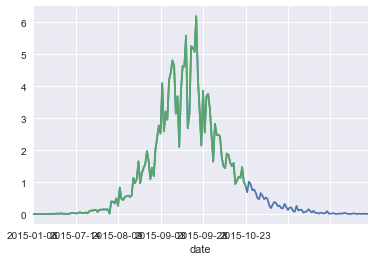

In [15]:
df.r.plot()
dftrain.plot()

In [16]:
print(ADF(dftrain,max_lags=10).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.450
P-value                         0.558
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The test result shows that we do not reject $H_0$, the data is **un-stationary**, since all the critical values are larger than Test statistic at the following significant levels:

$$-3.49 (1\%), -2.89 (5\%), -2.58 (10\%)<\color{red}{-1.45}$$

<p /><big>
**<font color="brown">Following Goal</font>**: Continue proceeding something to make the data stationary Since it is definitely <font color="gray">un-stationary</font>.
</big>

Stationary Transform
---
So now we need to transform the data to make it more stationary. There are various transformations we can untilize to data-stationary work, including:

1. Deflation by certain column of data,
- Logarithmic
- First Difference
- Seasonal Difference
- Seasonal Adjustment

Here, implement a function, ```test_stationarity(timeseries)```, which take over the works, calculating the moving average, standard deviation, making data plot, visualizing data with related statistical inferences: 


Normalized Data
---
Centred data 

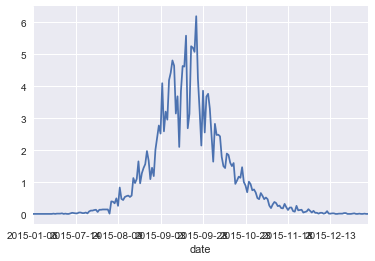

In [22]:
df.r.plot()

In [25]:
def test_stationarity(timeseries):
    """
    var timeseries;
    calculate the moving avagage with respect to mean and standard deviation of time series respectively,
    and output the result of ADF test, and its visualisation
    """
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd =  timeseries.rolling(window=12,center=False).std()         
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    
    #orig = plt.plot(timeseries, color='blue',label='Original')
    timeseries.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title="Rolling Mean & Standard Deviation"
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
    ylimp=max(max(timeseries),1)
    ylimm=min(min(timeseries),-1)
    plt.ylim(ylimm,ylimp)
    #plt.axes(frameon = 0)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    critical=np.array([0.,0.,0.])
    i=0
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        critical[i]=value
        i=i+1
    print(dfoutput )
    # do test hypotheses
    test=sum(critical>dfoutput[0])
    print("-----")
    if (test==3):
       print("Test:\n do not reject H0: Time Series is stationary, under 1% significant level.") 
       print("  stationary     1% xc   non-stationary")
       print("<-------x-----------|--------------->")
       print("      %5.2f       %5.2f " %(dfoutput[0],critical[0]))
    elif (test==2):
       print("Test:\n do not reject H0: Time Series is stationary, under 5% significant level.")  
       print("  stationary     1% xc   non-stationary")
       print("<------------------|---------x------>")
       print("                 %5.2f " %critical[0],"  %5.2f" %dfoutput[0])
    elif(test==1):
       print("  stationary     5% xc   non-stationary")
       print("<------------------|---------x------>")
       print("                 %5.2f " %critical[1],"  %5.2f" %dfoutput[0])
       print("Test:\n do not reject H0: Time Series is stationary, under 10% significant level.") 
    else:
       print("Test:\n do not reject H1: Time Series is un-stationary.") 
       print("  stationary     10% xc  non-stationary")
       print("<------------------|---------x------>")
       print("                 %5.2f " %critical[2],"  %5.2f" %dfoutput[0])

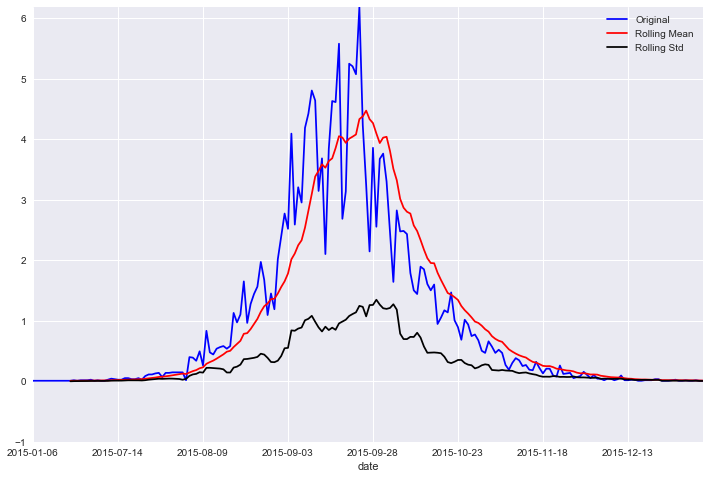

Results of Dickey-Fuller Test:
Test Statistic                  -2.001138
p-value                          0.286074
#Lags Used                      15.000000
Number of Observations Used    182.000000
Critical Value (5%)             -2.877555
Critical Value (10%)            -2.575308
Critical Value (1%)             -3.466800
dtype: float64
-----
Test:
 do not reject H1: Time Series is un-stationary.
  stationary     10% xc  non-stationary
<------------------|---------x------>
                 -3.47    -2.00


In [26]:
test_stationarity(df.r)

Firstly, to eliminate the unstationability, let us to take <font color="brown">a first order of difference of the data</font>, $x_t-x_{t-1}$. This always does help to eliminate the overall trend from the data.

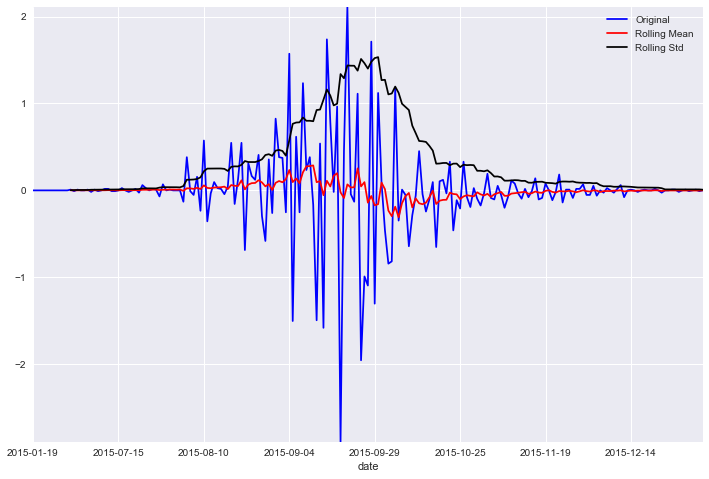

Results of Dickey-Fuller Test:
Test Statistic                  -3.808095
p-value                          0.002826
#Lags Used                       7.000000
Number of Observations Used    189.000000
Critical Value (5%)             -2.876957
Critical Value (10%)            -2.574988
Critical Value (1%)             -3.465431
dtype: float64
-----
Test:
 do not reject H0: Time Series is stationary, under 1% significant level.
  stationary     1% xc   non-stationary
<-------x-----------|--------------->
      -3.81       -2.88 


In [27]:
df['first_difference'] = df.r - df.r.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

```
From last result, we have successfully converted the time series data into stationary one by taking a first difference of the data. 
```
Note
If this transformation does not help to improve the stablization, we can keep trying the other refinement methods:
- ```df.Col - df.Col.shift(n)  ```, where `n` means data n shift time,
- take ```log``` over data
```python
   df_log=df.Col.apply(lambda x: np.log(x)) 
   df_log - df_log.shift(1) 
```   

3. Plot the ACF/PACF charts and find the optimal parameters
---


<big>

Having noise means 
```
 no prediction we can make, Since No information there
```
</big>


Besides the problem whether the time series data is stationary, we have to examine 
<code style="background-color:lightgrey;color:blue">
   whether the data is free of white noise;   <br>        
</code>
otherwise, there are nothing we can dig from it. 

Whether Noise-free
---
The **Ljung–Box test** (named for Greta M. Ljung and George E. P. Box) is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero, and used to test *whether is Noise-free*.

The Ljung–Box test may be defined as:

$\color{brown}{H_0}$: <font color="brown">The data are independently distributed</font> (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).<br>
$\color{brown}{H_a}$: <font color="brown">The data are not independently distributed</font>; they exhibit serial correlation.

The test statistic is
$$\mathbf{Q=n(n+2)\sum_{k=1}^h\frac{\hat\rho_k^2}{n-k}\sim\chi^2_h}$$
where $n$ is the sample size, 
$\hat\rho_k^2$ is the sample autocorrelation at lag $k$, and $h$ is the number of lags being tested. For significance level $\alpha$, the critical region for rejection of the hypothesis of randomness, $\color{brown}{H_0}$, is:
$$\mathbf{Q>\chi^2_{1-\alpha,h}}$$

```

     Random         Non-random 
<---------------|--------------->
               Qc
               
```



In [28]:
#df.first_difference[:-num]
dftrain=df.first_difference[:-num+1]
dftest=df.first_difference[-num+1:]
num,len(dftrain),len(dftest),len(df.first_difference)

(72, 127, 71, 198)

In [29]:
dftrain=dftrain.dropna()
len(dftrain),len(df.first_difference)

(126, 198)

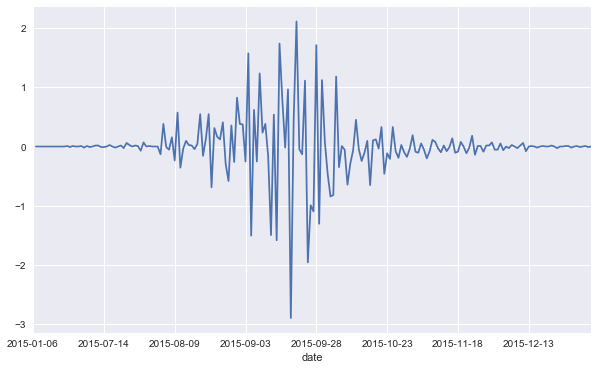

In [31]:
#dftrain.plot()
plt.figure(figsize=(10,6))
df.first_difference.plot()

In [32]:
print(ADF(dftrain,max_lags=10).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.950
P-value                         0.040
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


```
  stationary        5% Xc  non-stationary
<-------------x-------|------------------->
           -2.95    -2.89
```

Since under 5% significanr level, we do not reject the alternative hypotheses, $H_a$: the time series is stationary; another test function is implemented to test whether or not time series is free of white noise:

In [33]:
def ADFtest(timeseries,lags=10):
    train=timeseries[:-3]
    train=train.dropna()
    print(ADF(train,max_lags=lags).summary().as_text())
    
    LjungBox=stattools.q_stat(stattools.acf(train)[1:6],len(train))
    print("Ljung-Box value = ",LjungBox[1][-1])
    #model11=arima_model.ARIMA(train,order=(1,0,1)).fit()
    #print(model11.summary())
    return(train)

In [34]:
dftrain=ADFtest(dftrain)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.956
P-value                         0.039
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Ljung-Box value =  0.00258252591015


The result suggests that we do not reject $H_a$:, the time series data is not white-noise series, under 5% significant level. 

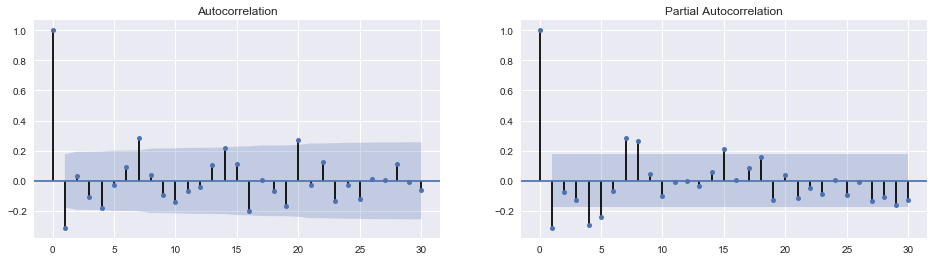

In [35]:
plt.figure(figsize=(16,4))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
plot1=plot_acf(dftrain,lags=30,ax=ax1)
plot2=plot_pacf(dftrain,lags=30,ax=ax2)

In [91]:
stattools.acf(dftrain)[1:]


array([-0.31278876,  0.03282249, -0.10566511, -0.18275011, -0.02731218,
        0.08998805,  0.2872627 ,  0.03841919, -0.09535957, -0.1426945 ,
       -0.06553083, -0.04426516,  0.10485045,  0.21496772,  0.10972933,
       -0.19768845,  0.00713759, -0.06699962, -0.1677774 ,  0.27026936,
       -0.02585167,  0.1243461 , -0.13479197, -0.02516434, -0.12257033,
        0.01421584,  0.00338613,  0.11447191, -0.00546707, -0.06239861,
        0.02786042, -0.0865191 , -0.02274492,  0.0809323 , -0.01703861,
        0.03056497, -0.05109078, -0.00239896, -0.03380647, -0.05904951])

This concludes, the data is non-whiteNoise data since $p$-value is almost equal to zero which is far from the general signinificant level,  e.g. $\alpha=0.05$.

The left is to identify which kind of model it is suitable and make prediction from this model.

4. ARMA Model Introduce
---
Predictor of ARIMA(p,q) model is composed of two parts:

1. Number of **AR** (Auto-Regressive) terms ($p$): AR terms are just lags of dependent variable: the predictors for $x_t$ will be
$$x_{t-1},x_{t-2},\cdots,x_{t-p}$$
- Number of **MA** (Moving Average) terms ($q$): MA terms are lagged forecast errors in prediction equation; the predictors for $X_t$ will be 
$$\varepsilon_{t-1},\varepsilon_{t-2},\cdots,\varepsilon_{t-q}$$
where $\varepsilon_{i}$ is the difference between the moving average at $i$-th instant and actual value.

**For instance**, ```ARMA(3,2)```

\begin{eqnarray}
   x_t &=& \phi_0+\phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+\varepsilon_t+\theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}
\end{eqnarray}   

Test
---
1. use arima_model of statsmodels;
- take the model which owns the least AIC (or BIC) value.

In [36]:
from statsmodels.tsa import arima_model

In [37]:
model11=arima_model.ARIMA(dftrain,order=(1,0,1)).fit()
print(model11.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(1, 1)   Log Likelihood                -110.843
Method:                       css-mle   S.D. of innovations              0.595
Date:                Thu, 08 Jun 2017   AIC                            229.686
Time:                        15:32:11   BIC                            240.934
Sample:                    01-19-2015   HQIC                           234.255
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0111      0.025      0.447      0.656      -0.037       0.060
ar.L1.first_difference     0.2806      0.141      1.990      0.049       0.004       0.557
ma.L

In [38]:
model12=arima_model.ARIMA(dftrain,order=(1,0,2)).fit()
print(model12.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(1, 2)   Log Likelihood                -110.816
Method:                       css-mle   S.D. of innovations              0.595
Date:                Thu, 08 Jun 2017   AIC                            231.631
Time:                        15:32:15   BIC                            245.692
Sample:                    01-19-2015   HQIC                           237.343
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0111      0.025      0.447      0.656      -0.038       0.060
ar.L1.first_difference     0.3407      0.284      1.202      0.232      -0.215       0.896
ma.L

In [39]:
model21=arima_model.ARIMA(dftrain,order=(2,0,1)).fit()
print(model21.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(2, 1)   Log Likelihood                -110.777
Method:                       css-mle   S.D. of innovations              0.595
Date:                Thu, 08 Jun 2017   AIC                            231.554
Time:                        15:32:17   BIC                            245.615
Sample:                    01-19-2015   HQIC                           237.265
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0111      0.025      0.446      0.656      -0.038       0.060
ar.L1.first_difference     0.2931      0.144      2.037      0.044       0.011       0.575
ar.L

In [40]:
model22=arima_model.ARIMA(dftrain,order=(2,0,2)).fit()
print(model22.summary())


                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(2, 2)   Log Likelihood                -103.905
Method:                       css-mle   S.D. of innovations              0.549
Date:                Thu, 08 Jun 2017   AIC                            219.810
Time:                        15:32:22   BIC                            236.683
Sample:                    01-19-2015   HQIC                           226.664
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0127      0.038      0.335      0.738      -0.061       0.087
ar.L1.first_difference     1.1997      0.047     25.391      0.000       1.107       1.292
ar.L

In [41]:
model23=arima_model.ARIMA(dftrain,order=(2,0,3)).fit()
print(model23.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(2, 3)   Log Likelihood                 -97.563
Method:                       css-mle   S.D. of innovations              0.521
Date:                Thu, 08 Jun 2017   AIC                            209.126
Time:                        15:32:25   BIC                            228.811
Sample:                    01-19-2015   HQIC                           217.122
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0114      0.025      0.449      0.654      -0.038       0.061
ar.L1.first_difference     1.2799      0.038     33.937      0.000       1.206       1.354
ar.L

/Users/chu-chinghuang/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [42]:
model31=arima_model.ARIMA(dftrain,order=(3,0,1)).fit()
print(model31.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(3, 1)   Log Likelihood                -108.964
Method:                       css-mle   S.D. of innovations              0.586
Date:                Thu, 08 Jun 2017   AIC                            229.928
Time:                        15:32:28   BIC                            246.801
Sample:                    01-19-2015   HQIC                           236.782
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0109      0.023      0.469      0.640      -0.035       0.056
ar.L1.first_difference     0.1880      0.142      1.323      0.188      -0.091       0.467
ar.L

In [46]:
model32=arima_model.ARIMA(dftrain,order=(3,0,2)).fit()
print(model32.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(3, 2)   Log Likelihood                 -96.076
Method:                       css-mle   S.D. of innovations              0.515
Date:                Thu, 08 Jun 2017   AIC                            206.153
Time:                        15:33:06   BIC                            225.838
Sample:                    01-19-2015   HQIC                           214.149
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0116      0.027      0.436      0.663      -0.041       0.064
ar.L1.first_difference     0.8963      0.085     10.582      0.000       0.730       1.062
ar.L

In [44]:
model33=arima_model.ARIMA(dftrain,order=(3,0,3)).fit()
print(model33.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(3, 3)   Log Likelihood                 -96.076
Method:                       css-mle   S.D. of innovations              0.515
Date:                Thu, 08 Jun 2017   AIC                            208.152
Time:                        15:32:51   BIC                            230.650
Sample:                    01-19-2015   HQIC                           217.291
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0116      0.027      0.436      0.664      -0.041       0.064
ar.L1.first_difference     0.8948      0.189      4.731      0.000       0.524       1.266
ar.L

/Users/chu-chinghuang/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [104]:
model33=arima_model.ARIMA(dftrain,order=(3,0,3)).fit()
print(model33.summary())

                              ARMA Model Results                              
Dep. Variable:       first_difference   No. Observations:                  123
Model:                     ARMA(3, 3)   Log Likelihood                 -96.076
Method:                       css-mle   S.D. of innovations              0.515
Date:                Thu, 30 Mar 2017   AIC                            208.152
Time:                        13:23:33   BIC                            230.650
Sample:                    01-19-2015   HQIC                           217.291
                         - 10-21-2015                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0116      0.027      0.436      0.664      -0.041       0.064
ar.L1.first_difference     0.8948      0.189      4.731      0.000       0.524       1.266
ar.L

In [47]:
print(" #AIC#\n ARIMA(1,1):%6.2f, ARIMA(1,1):%6.2f" %(model11.aic,model12.aic))
print(" ARIMA(2,1):%6.2f, ARIMA(2,2):%6.2f, ARIMA(2,3):%6.2f" %(model21.aic,model22.aic,model23.aic))
print(" ARIMA(3,1):%6.2f, ARIMA(3,2):%6.2f, ARIMA(3,3):%6.2f" %(model31.aic,model32.aic,model33.aic))

 #AIC#
 ARIMA(1,1):229.69, ARIMA(1,1):231.63
 ARIMA(2,1):231.55, ARIMA(2,2):219.81, ARIMA(2,3):209.13
 ARIMA(3,1):229.93, ARIMA(3,2):206.15, ARIMA(3,3):208.15


Comparing above suggests that the best model here is ARIMA($p=3,q=2$) since its AIC value is smallest, i.e.
\begin{eqnarray}
   x_t &=& \phi_0+\phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+\varepsilon_t+\theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}\\
       &=& 0.0116+0.90x_{t-1}-0.44x_{t-2}-0.35x_{t-3}+\varepsilon_t-1.50\varepsilon_{t-1}+1.0\varepsilon_{t-2}
\end{eqnarray}   

In [48]:
print(model32.summary().tables[1])

                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0116      0.027      0.436      0.663      -0.041       0.064
ar.L1.first_difference     0.8963      0.085     10.582      0.000       0.730       1.062
ar.L2.first_difference    -0.4378      0.109     -4.025      0.000      -0.651      -0.225
ar.L3.first_difference    -0.3507      0.085     -4.136      0.000      -0.517      -0.185
ma.L1.first_difference    -1.4896      0.037    -40.460      0.000      -1.562      -1.417
ma.L2.first_difference     1.0000      0.045     22.291      0.000       0.912       1.088


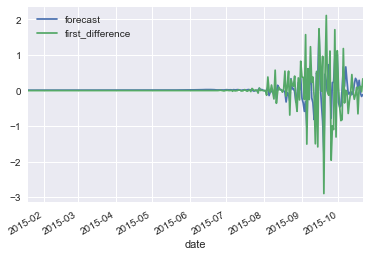

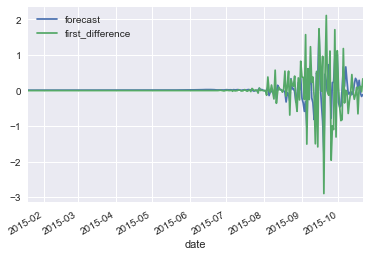

In [50]:
plt.figure(figsize=(12,6))
model32.plot_predict()

In [51]:
model32.conf_int()

,0,1
const,-0.040506,0.063698
ar.L1.first_difference,0.730319,1.062338
ar.L2.first_difference,-0.651036,-0.224640
ar.L3.first_difference,-0.516919,-0.184507
ma.L1.first_difference,-1.561804,-1.417482
ma.L2.first_difference,0.912072,1.087928


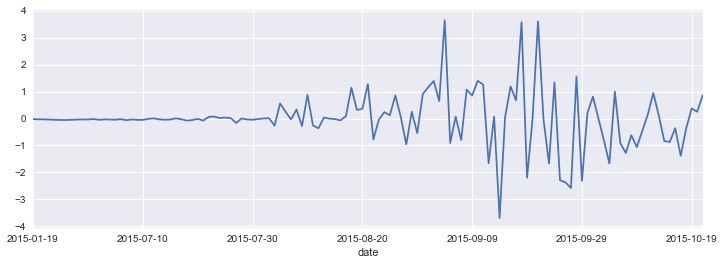

In [53]:
stdresid=model32.resid/np.sqrt(model32.sigma2)
plt.figure(figsize=(12,4))
stdresid.plot()


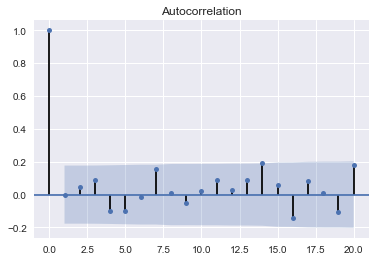

In [54]:
plot_acf(stdresid,lags=20);


In [123]:
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:20],len(stdresid))
LjungBox[1][-1]

0.30010120928507966

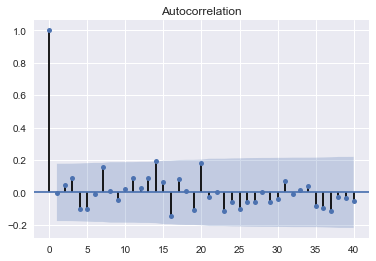

In [55]:
plot_acf(stdresid,lags=40);


5. Forecast System
---
After training the data, we select the best fit model and use it to generate the predict data within the the left time period. Here we use the function to do the word
```
(model32.forecast(size)[0]
```
where **size** is the size of predicted data we want to generate after training date time.

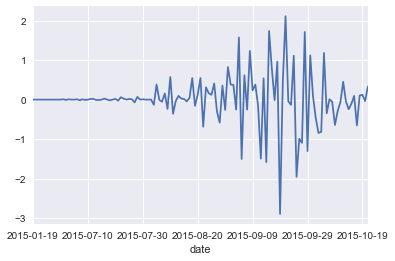

In [56]:
dftrain.plot()

In [57]:
a=len(df['first_difference'])-len(dftrain)
# create a new column of dataframe with zero value
df['predict']=0
# generate the predicted data and reset the new column
pred_num=len(model32.forecast(a-1)[0])
df.predict[-pred_num:]=model32.forecast(a-1)[0]

/Users/chu-chinghuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
a=len(df['first_difference'])-len(dftrain)
# create a new column of dataframe with zero value
#df['predict']=0
df['predict']=df.first_difference
# generate the predicted data and reset the new column
pred_num=len(model32.forecast(a-1)[0])
df.predict[-pred_num:]=model32.forecast(a-1)[0]

/Users/chu-chinghuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now take a look on our effort,

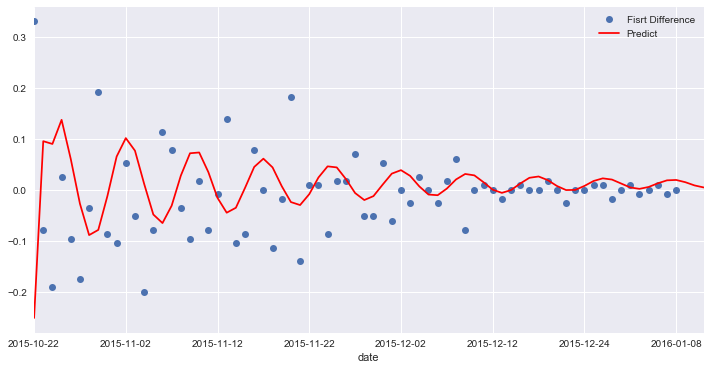

In [59]:
dftest.plot(style='o',label='Fisrt Difference',figsize=(12,6))
df.predict[-pred_num:].plot(color="red",label='Predict')
plt.legend()

Converted back the original quantity
---

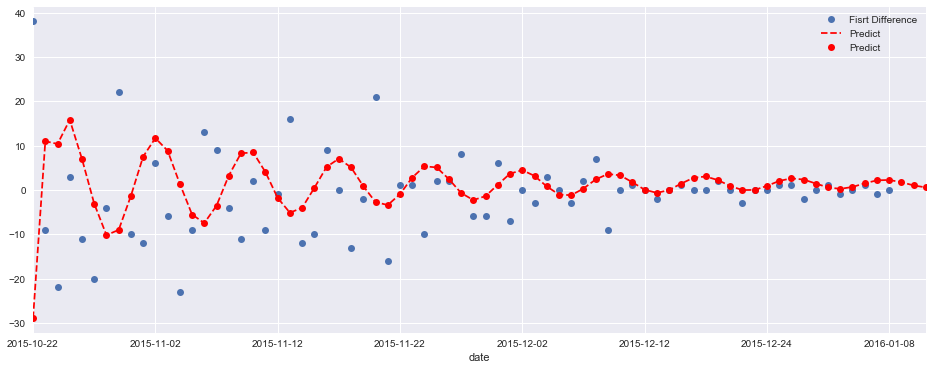

In [60]:
(df.num.mean()*dftest).plot(style='o',label='Fisrt Difference',figsize=(16,6))
(df.num.mean()*df.predict[-pred_num:]).plot(style='--',color="red",label='Predict')
(df.num.mean()*df.predict[-pred_num:]).plot(style='ro',label='Predict')
plt.legend()

In [61]:
df_first_difference_cumsum=df.num.mean()*(df.r.cumsum())

In [62]:
df_first_difference_cumsum=df.num.mean()*(df.first_difference.cumsum())

In [63]:
df_predict_first_difference_cumsum=df.num.mean()*(df.predict.cumsum())+1

In [64]:
df_predict_first_difference_cumsum+1

date
2015-01-06           NaN
2015-01-19      2.000000
2015-05-21      2.000000
2015-05-24      2.000000
2015-06-04      2.000000
2015-06-11      2.000000
2015-06-14      2.000000
2015-06-18      2.000000
2015-06-21      2.000000
2015-06-22      2.000000
2015-06-23      2.000000
2015-06-24      2.000000
2015-06-26      3.000000
2015-06-29      2.000000
2015-07-01      3.000000
2015-07-03      3.000000
2015-07-04      3.000000
2015-07-05      4.000000
2015-07-06      2.000000
2015-07-07      3.000000
2015-07-08      2.000000
2015-07-10      2.000000
2015-07-11      4.000000
2015-07-12      6.000000
2015-07-13      5.000000
2015-07-14      4.000000
2015-07-15      4.000000
2015-07-16      7.000000
2015-07-17      7.000000
2015-07-18      5.000000
                 ...    
2015-12-06    220.926049
2015-12-07    221.222064
2015-12-08    223.573554
2015-12-09    227.164474
2015-12-10    230.440389
2015-12-11    232.170404
2015-12-12    232.218023
2015-12-13    231.544993
2015-12-14    231.50

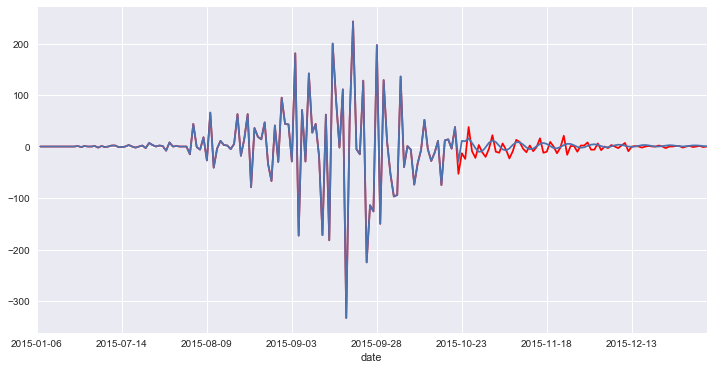

In [65]:
(df.num.mean()*df.first_difference).plot(color='red',figsize=(12,6))
(df.num.mean()*df.predict).plot()

In [ ]:
df_first_difference_cumsum.plot()
df_predict_first_difference_cumsum.plot()

FaceBook Prophet Introduction
---
One of most simple prediction package this year for time-series, especially for economical data. You should love it from now on!

In [66]:
from fbprophet import Prophet
import pandas_datareader.data as web

#import pandas_datareader as pdr
from pandas_datareader import data as pdr
import fix_yahoo_finance  # <== that's all it takes :-)

In [67]:
df1=df[40:-30]

In [68]:
df1.head(5)

,num,r,first_difference,predict
date,,,,
2015-07-29,16,0.139033,0.00000,0.00000
2015-07-30,17,0.147722,0.00869,0.00869
2015-07-31,17,0.147722,0.00000,0.00000
2015-08-01,17,0.147722,0.00000,0.00000
2015-08-02,17,0.147722,0.00000,0.00000


In [69]:
df1['y'] = df1['num']

df1['ds'] = pd.to_datetime(df1.index)

/Users/chu-chinghuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/chu-chinghuang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [70]:
df1.tail(5)

,num,r,first_difference,predict,y,ds
date,,,,,,
2015-12-01,12,0.104275,-0.052137,0.031893,12,2015-12-01
2015-12-02,6,0.052137,-0.052137,0.038705,6,2015-12-02
2015-12-03,12,0.104275,0.052137,0.027464,12,2015-12-03
2015-12-04,5,0.043448,-0.060827,0.006831,5,2015-12-04
2015-12-05,5,0.043448,0.000000,-0.009130,5,2015-12-05


Modeling Prediction
---

- Input ```df.ds, df.y```: datetime and data we want to predict, define them if none;
- Output ```df.yhat, df.yhat_upper, df.yhat_lower```: 95% CI's

In [78]:
#model = Prophet(mcmc_samples=500)
model = Prophet()
model.fit(df1);

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [79]:
# Extend date range
future = model.make_future_dataframe(periods=14)
future.tail()

,ds
137,2015-12-15
138,2015-12-16
139,2015-12-17
140,2015-12-18
141,2015-12-19


predict for $\hat{\! y}$ and its lower/upper bounds:

In [97]:
forecast = model.predict(future)
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
132,2015-12-10,-79.364399,-184.594571,34.082349
133,2015-12-11,-89.919966,-202.098799,22.116617
134,2015-12-12,-150.455438,-268.132024,-35.621275
135,2015-12-13,-170.179519,-277.389712,-64.238744
136,2015-12-14,-135.788047,-247.418250,-23.254069
137,2015-12-15,-129.027880,-243.014819,-16.408260
138,2015-12-16,-121.183528,-234.526100,-3.416881
139,2015-12-17,-122.585979,-236.388603,-11.441001
140,2015-12-18,-133.141546,-245.009973,-23.907019
141,2015-12-19,-193.677018,-306.160913,-75.063258


In [98]:
f=forecast[3:]

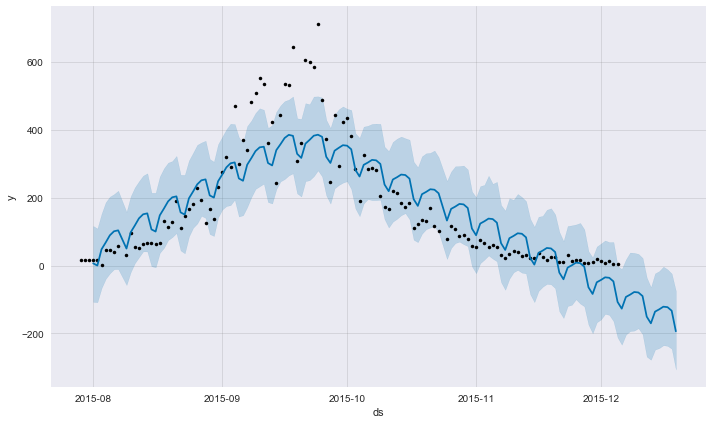

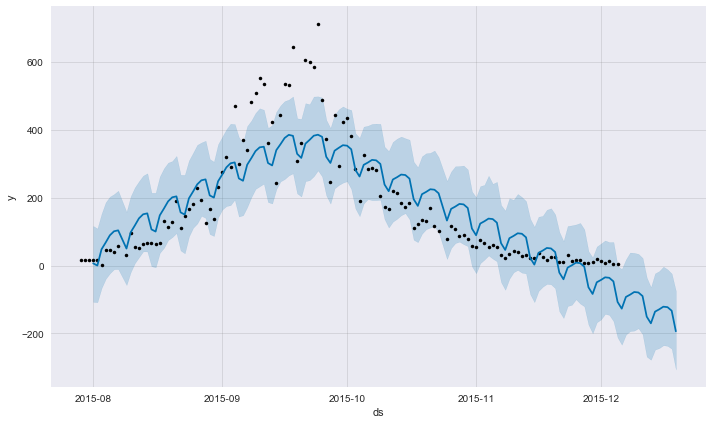

In [99]:
model.plot(f)

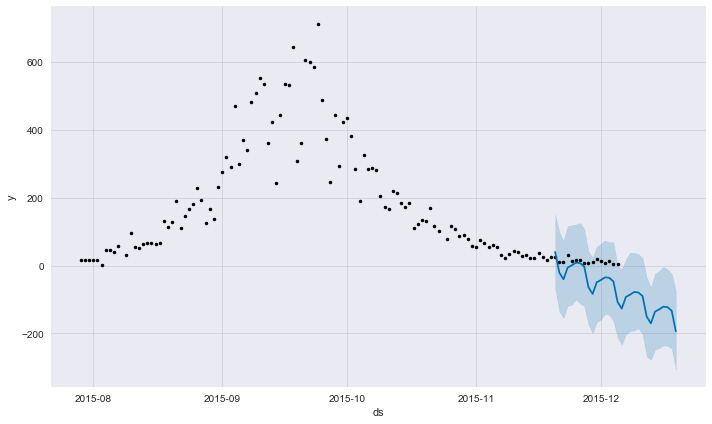

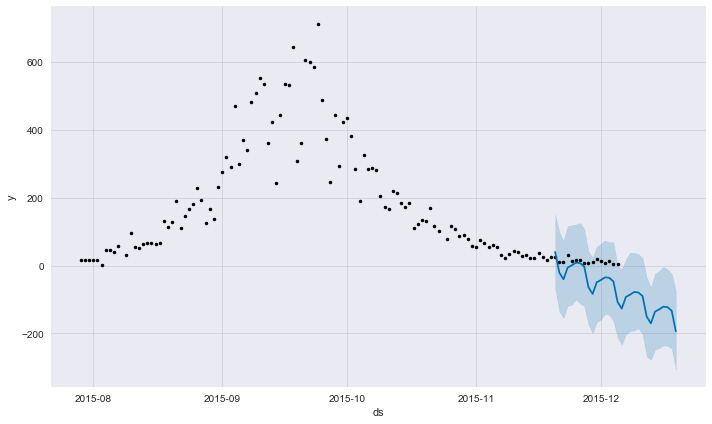

In [100]:
model.plot(forecast[-30:])